> **Andrew Bauer**
> 
> 913-671-0313
> 
> abauer7@asu.edu

----

# For Interactive Version try it on [Google Colab](https://colab.research.google.com/drive/1HkM5sumCGutjZLHW3eh8ynR4g7aaUW7x?usp=sharing)
-------------

# Introduction

The game of Monopoly is played on a board with 40 spaces. Players roll dice to move. Depending on which space a player lands on, they may be able to purchase a property, be forced to pay, or one of many other effects. Movement in Monopoly is hugely important, but completely probabilistic. As such, we would like to be able to describe the probability distribution of a player after an arbitrary number of turns.

Below we will work through a mathematical method of calculating the probability distribution after $n$ turns as well as the distribution as $n \to \infty$. Then we will also calculate the average number of turns required to travel from one space to another.

In [1]:
import numpy as np
import helper as helper
from functools import lru_cache as memoize
from itertools import product
from ipywidgets import interact
from matplotlib import pyplot

## Monopoly Board

![](https://pbs.twimg.com/media/DMW3Pl7X4AEPFCG.jpg)


# Representation

We can think of the monopoly board as a *graph*. Each space is a *node* and the different movement options between spaces are represented as *edges*.

Furthermore, the movement is completely probabilistic and the distribution is entirely determined by the current node (this type of graph is known as a [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain)). We then can assign a weight to each edge, corresponding to the probability of moving from a given tile to another tile. Graph edges can be represented in multiple ways, but in our case we will choose to represent them by an [Adjacency Matrix](https://en.wikipedia.org/wiki/Adjacency_matrix). In order to make this representation work, we need to have some way to represent the spaces as numbers. 

Below we have each tile listed (clockwise starting from Go). We will number each space in order starting from 0. So, for example, Go is space 0, Boardwalk is space 39. 

Jail is split across 3 spaces. Jail (40) is for players who just arrived. Jail (41) is for players who were in jail previously but failed to roll doubles. If a player fails to roll doubles on the second turn in jail, they will be released next turn regardless of what they roll. For this reason, if a player fails to roll doubles on the second turn, they are sent to the Just Visiting space. 

In [2]:
helper.SPACES

[' 0. Go',
 ' 1. Mediterranean Avenue',
 ' 2. Community Chest',
 ' 3. Baltic Avenue',
 ' 4. Income Tax',
 ' 5. Reading Railroad',
 ' 6. Oriental Avenue',
 ' 7. Chance',
 ' 8. Vermont Avenue',
 ' 9. Connecticut Avenue',
 '10. Just Visiting',
 '11. St. Charles Place',
 '12. Electric Company',
 '13. States Avenue',
 '14. Virginia Avenue',
 '15. Pennsylvania Railroad',
 '16. St. James Place',
 '17. Community Chest',
 '18. Tennessee Avenue',
 '19. New York Avenue',
 '20. Free Parking',
 '21. Kentucky Avenue',
 '22. Chance',
 '23. Indiana Avenue',
 '24. Illinois Avenue',
 '25. B&O Railroad',
 '26. Atlantic Avenue',
 '27. Ventnor Avenue',
 '28. Water Works',
 '29. Marvin Gardens',
 '30. Go to Jail',
 '31. Pacific Avenue',
 '32. North Carolina Avenue',
 '33. Community Chest',
 '34. Pennsylvania Avenue',
 '35. Short Line',
 '36. Chance',
 '37. Park Place',
 '38. Luxury Tax',
 '39. Boardwalk',
 '40. Jail',
 '41. Jail']

Now we will let $T \in \mathbb{R}^{42 \times 42}$ be the adjacency matrix so that $T_{i,j}$ is the probability of transitioning to state $i$ from state $j$. For example, $T_{40, 0} = 0.5$, means that starting from Go, there is a 50% chance to finish the turn in Jail. We also can see that $\sum_{i=0}^{41}T_{i,j} = 1$ for any $j$ (there is a 100% chance that the player will still be on the board after moving). 

Now we will construct the adjacency matrix, $T$. We will divide this process into two steps. 

* First, we will find the probability of getting a specific roll. In Monopoly, rolling doubles allows the player to roll again and add that to their total. However, if the player rolls doubles three times in a row, they go to jail.

* Then, we will account for certain board effects, such as cards and jail. [Chance](https://monopoly.fandom.com/wiki/Chance) and [Community Chest](https://monopoly.fandom.com/wiki/Community_Chest) decks are assumed to be reshuffled after each draw for simplicity.

In [3]:
dice = (1,2,3,4,5,6)
@memoize(3)
def generate_dice_pdf(doubles_left=3) -> (np.ndarray, float):
  """Generate the probability distribution arising from dice

  This function finds the probability distribution from rolling two dice while
  accounting for doubles. The argument doubles_left specifies how many times 
  you need to roll doubles to get jailed (by default 3). The function returns a
  tuple (prob, jail). 'prob' is a numpy array where prob[i] is the probability 
  of rolling i. 'prob' has shape (12*doubles_left,) as rolling 12*doubles_left
  or higher would require rolling doubles at least doubles_left number of times.
  'jail' is a number corresponding to the probability of going to jail.
  """
  prob = np.zeros(12 * doubles_left) 
  jail = 0
  for i, j in product(dice, dice): # Roll two dice
    if i == j:
      # Doubles
      if doubles_left > 1:
        nested_prob, nested_jail = generate_dice_pdf(doubles_left-1)
        jail += nested_jail / 36
        # Add the probabilities, but shift them by i+j
        prob[i+j:i+j+len(nested_prob)] += nested_prob / 36
      else:
        # Three doubles, go directly to jail!
        jail += 1/36
    else:
      prob[i+j] += 1/36
  assert np.isclose(prob.sum() + jail, 1), (prob, jail)
  return prob, jail

for roll, p in enumerate(generate_dice_pdf()[0]):
  print(f" {roll:2}  | {100*p:4.1f}%")
print(f"Jail | {100*generate_dice_pdf()[1]:4.1f}%")

  0  |  0.0%
  1  |  0.0%
  2  |  0.0%
  3  |  5.6%
  4  |  5.6%
  5  | 11.3%
  6  | 11.3%
  7  | 17.1%
  8  | 11.6%
  9  | 12.1%
 10  |  6.3%
 11  |  6.8%
 12  |  1.0%
 13  |  1.5%
 14  |  1.0%
 15  |  1.5%
 16  |  1.0%
 17  |  1.4%
 18  |  0.9%
 19  |  1.1%
 20  |  0.6%
 21  |  0.7%
 22  |  0.3%
 23  |  0.3%
 24  |  0.1%
 25  |  0.2%
 26  |  0.1%
 27  |  0.1%
 28  |  0.1%
 29  |  0.1%
 30  |  0.0%
 31  |  0.0%
 32  |  0.0%
 33  |  0.0%
 34  |  0.0%
 35  |  0.0%
Jail |  0.5%


In [4]:
def adjacency_matrix() -> np.ndarray(shape=(42, 42)):
  """Create the full adjacency matrix for Monopoly

  T[i, j] is probability of going to i from j
   - T[:, j] must sum to 1
  """
  T = np.zeros((42,42))
  dice_pdf, jail = generate_dice_pdf()
  assert dice_pdf.sum() + jail == 1

  for i in range(40):
    # The line below is almost equivalent to 
    # trans[i:i+36, i] = dice_pdf
    # Except that it will wrap around if the index goes past 40
    T[:40,i].put(range(i,i+36), dice_pdf, mode='wrap')
    T[40,i] += jail

    # Handle Chance's, Community Chest's, and the Go to Jail space
    for chance in helper.CHANCE:
      card_chance = T[chance,i]/16 # Chance of drawing any given card
      T[chance,i] -= card_chance * 9 # There are 9 movement cards
      T[0,i]  += card_chance # Advance to Go
      T[24,i] += card_chance # Advance to Illinois Ave
      T[11,i] += card_chance # Advance to St. Charles Place
      T[i-3,i]+= card_chance # Go Back 3 Spaces
      T[40,i] += card_chance # Go to Jail
      T[5,i]  += card_chance # Take a trip to Reading Railroad
      T[39,i] += card_chance # Take a walk on the Boardwalk
      T[helper.next_railroad(i), i] += card_chance # Advance to the nearest Railroad
      T[28 if 12 <= i < 28 else 12,i] += card_chance # Advance to nearest Utility

    for community in helper.COMMUNITY_CHEST:
      card_chance = T[community,i]/17 # Chance of drawing any given card
      T[community,i] -= card_chance * 2 # There are 2 movement cards
      T[0,i]  += card_chance # Advance to Go
      T[40,i] += card_chance # Go to Jail

    for gtj in helper.GO_TO_JAIL:
      T[40,i] += T[gtj,i]
      T[gtj,i] = 0

  # Jail
  # On the first (40) and second (41) turn, the player has a 1/6 chance of
  # rolling doubles. In this case, they are effectively in the "Just Visiting"
  # space. Otherwise they move to the next turn of jail. On the third turn,
  # they are let go, regardless of whether they roll doubles, so effectively 
  # they are in the "Just Visiting" space (10)
  T[:,40] = T[:,10] / 6
  T[:,41] = T[:,10] / 6
  T[41,40] = 5/6
  T[10,41] = 5/6

  assert np.allclose(T.sum(axis=0), 1), "Probabilities do not add up"
  return T

T = adjacency_matrix()

Now, we may want to also define a player's position. We can do so with a probability vector, for example, $p \in \mathbb{R}^{42}$. Then $p_i$ represents the probability that the player is in state $i$. 

For example, a player who is on Go with certainty would be described by the vector $$
p = \begin{bmatrix}
           1 \\
           0 \\
           \vdots \\
           0
\end{bmatrix}
$$

In [5]:
def state(i: range(0,42)) -> np.ndarray(shape=(42, 1)):
  """Probability vector for being in state i with certainty
  
  This is the same as onehot encoding with a maximum size of 42
  """
  if i < 0 or 42 <= i:
    raise ValueError(f"Expected 0 <= i < 42, instead got {i}.")
  s = np.zeros((42, 1))
  s[i] = 1
  return s

# Probability Distribution after 1 turn

Now, let $u, v \in \mathbb{R}^{42}$ where $u$ is the probability distribution associated with a player before movement and $v$ is the probability distribution after movement. Then we know that 
$$
\begin{align}
v_i &= \sum_{j=0}^{41} T_{i, j} u_{j} \\
&= (T u)_i
\end{align}
$$ 

And therefore $v = T u$, (matrix multiplication)

Below you can use the drop down box to preview what happens when you move, starting from a specific state.

In [6]:
@interact
def from_start(space=helper.SPACES):
  # Note that in numpy
  # * is elementwise multiplication
  # @ is matrix multiplcation
  print(helper.format(T @ state(helper.SPACES.index(space))))

interactive(children=(Dropdown(description='space', options=(' 0. Go', ' 1. Mediterranean Avenue', ' 2. Commun…

# Generalizing to $n$ turns

Now, if we let $v^{(0)}$ be the starting probability distribution, then $v^{(1)} = Tv^{(0)}$ is the probability distribution after one turn, and $v^{(2)} = Tv^{(1)}$ is the distribution after two turns. In general $$v^{(n+1)} = Tv^{(n)} = \underbrace{T T \cdots T}_{n}v^{(0)} = T^n v^{(0)}$$

Now, we can find the probability distribution after $n$ turns by calculating $T^n v^{(0)}$, however, we can simplify this further. We will decompose $T$ into its eigenvalues, $\lambda_i$ (together as $\Lambda$) and eigenvectors $\omega_i$ (together as $\Omega$). Then $T \omega_i = \lambda_i \omega_i$ and $T \Omega = \lambda \cdot \Omega$ (elementwise multiplcation). Then we find that $T^n\omega_i = \lambda_i^n \omega_i$ (so $T^n\Omega = \Lambda^n \cdot \Omega$ with $\Lambda^n$ being elementwise). Then

$$\begin{align}
v^{(n)} &= T^nv^{(0)} \\
&= T^n \Omega \Omega^{-1} v^{(0)} \\
&= (\Lambda^n \cdot \Omega) \Omega^{-1} v^{(0)} \\
\end{align}$$

Below we create the $n$-move transition matrix: $T^n = (\Lambda^n \cdot \Omega) \Omega^{-1}$.

In [7]:
Lambda, Omega = np.linalg.eig(T)
Omega_inv = np.linalg.inv(Omega)

def transition_n(n: int) -> np.ndarray:
  """Generate a transition matrix for moving n turns
  
  Returns a transition matrix of shape (42, 42). Multiplying by this matrix is
  the same as multiplying by T n times and results in the probability 
  distribution n turns later.
  """
  if n < 0:
    raise ValueError(f"Expected n >= 0, instead got {n}.")
  trans = (Lambda**n * Omega) @ Omega_inv
  assert np.isclose(trans.imag, 0).all(), "All the complex numbers should cancel out"
  return trans.real

Now we can preview the probability of landing on any given tile after $n$ moves. Use the drop down box to select the starting location and the slider to decide how many turns ($n$).

In [8]:
@interact
def n_from_start(starting_state=helper.SPACES, n=(0, 10, 1)):
  print(helper.format(transition_n(n) @ state(helper.SPACES.index(starting_state))))

interactive(children=(Dropdown(description='starting_state', options=(' 0. Go', ' 1. Mediterranean Avenue', ' …

# Generalizing as $n \to \infty$ turns

Now a natural question is what happens with 

$$v^{(\infty)}=\lim_{n\to\infty}v^{(n)}$$

That is quite a significant question, as it represents the long term probability that a player is on any given tile. This can be used to determine how much to value a certain space. For example, $v^{(\infty)}_{19} = 3.18$% (Illinois Avenue). Taking this into account we can figure out the expected income (per turn per opponent) and create the following table.

**Illinois Avenue**

Houses | 0 | 1 | 2 | 3 | 4
-------|---:|---:|---:|---:|--:
Cost   |\\$200 |\\$350 |\\$500 |\\$650 |\\$800
Rent   |\\$20 |\\$100 |\\$300 |\\$750 |\\$925
Income |\\$0.56|\\$2.78|\\$8.33|\\$20.83|\\$25.69
ROI |0.28%|0.79%|1.67%|3.2%|3.21%
Breakeven |360.1|126.0|60.0|31.2|31.1

We can make an equivalent table for Boardwalk ($v^{(\infty)}_{39}=2.62$%):

**Board Walk**

Houses | 0 | 1 | 2 | 3 | 4
-------|---:|---:|---:|---:|--:
Cost   |\\$400|\\$600|\\$800|\\$1000|\\$1200
Rent   |\\$35|\\$175|\\$500|\\$1100|\\$1300
Income |\\$0.87|\\$4.35|\\$12.43|\\$27.34|\\$32.31
ROI |0.22%|0.72%|1.55%|2.73%|2.69%
Breakeven |459.9|138.0|64.4|36.6|37.1

The charts suggest that Illinois Avenue is a better investment than Board Walk.

------

Now we would like to calculate $v^{(\infty)}$. 

We know that $$v^{(\infty)} = \lim_{n \to \infty} v^{(n)} = \lim_{n\to\infty}(\Lambda^n \cdot \Omega) \Omega^{-1} v^{(0)}$$

Additionally, we know that for any number, $r \in \mathbb{R}$, if $|r| < 1$, $\lim_{n\to\infty}r^n = 0$. Furthermore, we see that $\lambda_0 = 1$ (we can prove this too), but otherwise $|\lambda_i| < 1$. Therefore 
$$
\lim_{n \to \infty} \Lambda^n = 
\begin{bmatrix}
1\\
0\\
0\\
\vdots\\
0
\end{bmatrix}
$$

Then 

$$\lim_{n\to\infty} \Lambda^n \cdot \Omega = \omega_0$$

Therefore, 

$$\lim_{n\to\infty}(\Lambda^n \cdot \Omega) \Omega^{-1} v^{(0)} = \omega_0 (\Omega^{-1})_0^Tv^{(0)}$$

However, if we look at $(\Omega^{-1})_0$, we see:

In [9]:
assert np.isclose(Omega_inv[0,:].imag, 0).all(), "There should be no imaginary component"
for i, j in product(range(0, 42), range(0, 42)):
  assert np.isclose(Omega_inv[0,i], Omega_inv[0,j])
Omega_inv[0,:].real

array([0.16135371, 0.16135371, 0.16135371, 0.16135371, 0.16135371,
       0.16135371, 0.16135371, 0.16135371, 0.16135371, 0.16135371,
       0.16135371, 0.16135371, 0.16135371, 0.16135371, 0.16135371,
       0.16135371, 0.16135371, 0.16135371, 0.16135371, 0.16135371,
       0.16135371, 0.16135371, 0.16135371, 0.16135371, 0.16135371,
       0.16135371, 0.16135371, 0.16135371, 0.16135371, 0.16135371,
       0.16135371, 0.16135371, 0.16135371, 0.16135371, 0.16135371,
       0.16135371, 0.16135371, 0.16135371, 0.16135371, 0.16135371,
       0.16135371, 0.16135371])

Each entry is identical. Therefore consider $c = (\Omega^{-1})_{0,i}$. Then

$\begin{align*}
(\Omega^{-1})^T_0 v^{(0)} 
&= \sum_{i=0}^{41} c v^{(0)}_i\\
&= c \sum_{i=0}^{41}v_i^{(0)}\\
&= c
\end{align*}$ 

Where the last line is true since $v_i^{(0)}$ was a probability vector and must sum to $1$. 

Therefore we can see that 

$$v^{(\infty)} = \omega_0 (\Omega^{-1})_0^Tv^{(0)} = c \omega_0$$

Notice that $v^{(\infty)}$ has no dependence on $v^{(0)}$. This means that in the long run it does not matter where you started.

Additionally, since $c$ is just a constant, and since $v^{(\infty)}$ must be a probability vector (and must sum to $1$), we see that $c = \left(\sum_{n=0}^{41}\omega_i \right)^{-1}$.

Now we are finally ready to calculate $v^{(\infty)}$.

In [10]:
assert np.isclose(Omega[:,0].imag, 0).all(), "The imaginary part should cancel out"
omega0 = Omega[:,0].real
c = 1 / omega0.sum()
v_inf = (omega0 * c)[:,None]
print(helper.format(v_inf))

 0. Go                    :  3.01%
 1. Mediterranean Avenue  :  2.03%
 2. Community Chest       :  1.90%
 3. Baltic Avenue         :  2.08%
 4. Income Tax            :  2.14%
 5. Reading Railroad      :  2.69%
 6. Oriental Avenue       :  2.20%
 7. Chance                :  0.96%
 8. Vermont Avenue        :  2.25%
 9. Connecticut Avenue    :  2.22%
10. Just Visiting         :  4.81%
11. St. Charles Place     :  2.59%
12. Electric Company      :  2.36%
13. States Avenue         :  2.30%
14. Virginia Avenue       :  2.28%
15. Pennsylvania Railroad :  2.61%
16. St. James Place       :  2.58%
17. Community Chest       :  2.51%
18. Tennessee Avenue      :  2.68%
19. New York Avenue       :  2.78%
20. Free Parking          :  2.60%
21. Kentucky Avenue       :  2.64%
22. Chance                :  1.09%
23. Indiana Avenue        :  2.53%
24. Illinois Avenue       :  2.99%
25. B&O Railroad          :  2.63%
26. Atlantic Avenue       :  2.55%
27. Ventnor Avenue        :  2.47%
28. Water Works     

# Visualizing Results

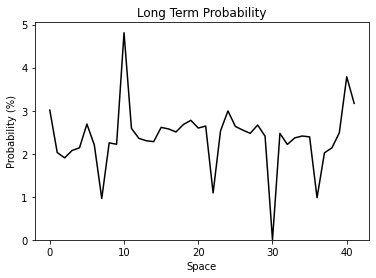

In [11]:
helper.plot_long_term_probability(v_inf)

We see that by far the most visited spaces are Jail. Additionally, we see that the spaces in the middle are quite common. This is likely because they are easily accessible from jail (check out $T v_{10}$ above).

Below is an interactive chart that shows the probability of traveling from a given tile to another given tile after $n$ turns. The numbers are calculated from the formula $(\Lambda^n \cdot \Omega) \Omega^{-1}$. Select the drop down box to see the transitions over different numbers of. We can clearly see the graph flatten out into large waves. The waves correspond to the larger eigenvalues. Eventually we are left with only $\omega_0$.

interactive(children=(Dropdown(description='n', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, '∞'), value…

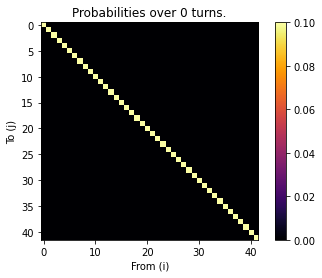

In [12]:
@interact
def probabilities_after_n_turns(n=[i for i in range(13)] + ['∞']):
  if n == '∞':
    pyplot.imshow(np.tile(v_inf, 42), 'inferno', vmin=0.0, vmax=0.1)
  else:
    pyplot.imshow(transition_n(n), 'inferno', vmin=0.0, vmax=0.1)
  pyplot.colorbar()
  pyplot.xlabel("From (i)")
  pyplot.ylabel("To (j)")
  pyplot.title(f"Probabilities over {n} turn{'' if n == 1 else 's'}.")


----

# Average time to reach a space

Another question we may wonder about is how long does it take, on average, to get from one space to another.

We will define $A_{i,j}$ as the average number of turns to reach state $i$ from state $j$. 

Then we find that for $i \neq j$, $$A_{i,j} = 1 + \sum_{k=0}^{41} A_{i,k}T_{k,j} = 1 + (AT)_{i,j}$$

with $A_{i,i} = 0$. 

Then for $i \neq j$, we see that:

$\begin{align}
A_{i, j} - (AT)_{i, j} &= 1\\
(AI)_{i, j} - (AT)_{i, j} &= 1\\
(A(I-T))_{i, j} &= 1
\end{align}$

Now we will define $A^{\neg i}$ and $T^{\neg i}$ to be $A$ and $T$ without row and column $i$. Then that means that 

$\begin{align}
A^{\neg i}(I-T^{\neg i}) &= 1\\
A^{\neg i}(I-T^{\neg i}) &= 1\\
A^{\neg i} &= 1(I-T^{\neg i})^{-1}\\
A^{\neg i}_{i,:} &= \sum_{k=0}^{41}(I-T^{\neg i})^{-1}_{k,:}\\
\end{align}$



In [13]:
A = np.zeros((42, 42))
for i in range(42):
  # mask is ignoring the ith entry
  mask1 = np.arange(42) != i
  mask2 = np.logical_and.outer(mask1, mask1)
  A[i, mask1] = np.linalg.inv(np.eye(41) - T[mask2].reshape(41,41)).sum(axis=0)

Below is a tool to calculate the average number of turns required to go from space $a$ to space $b$. Use the drop down boxes to select the start and end space.

In [14]:
@interact
def average_from_a_to_b(a=helper.SPACES, b=helper.SPACES):
  print(f"On average it takes {A[helper.SPACES.index(b), helper.SPACES.index(a)]:.1f} turns to get from {a[4:]} ({a}) to {b[4:]} ({b})")

interactive(children=(Dropdown(description='a', options=(' 0. Go', ' 1. Mediterranean Avenue', ' 2. Community …

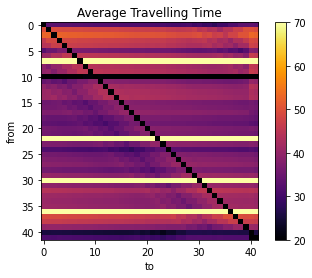

In [15]:
helper.plot_average_travel_time(A)

----

# Checking each step

Many algebraic manipulations were made. To ensure that we did not make a mistake, we can use asset statements to check our work. If there is a mistake, the asserts will throw an error.

To do so, we will estimate $v^{(\infty)} \approx v^{(100,000)}$:

In [16]:
temp = T
for i in range(100_000): temp = T @ temp
temp = temp @ state(0)

We know that $v^{(100,000)} = (\Lambda^{100,000} \cdot \Omega)\Omega^{-1}v^{(0)}$:

In [17]:
assert np.allclose((Lambda**100_000 * Omega) @ Omega_inv @ state(0), temp)

We also should check that 
$$
\lim_{n \to \infty} \Lambda^n = 
\begin{bmatrix}
1\\
0\\
0\\
\vdots\\
0
\end{bmatrix}
$$

In [18]:
Lambda_inf = np.array([1 if i == 0 else 0 for i in range(42)])
assert np.allclose(Lambda_inf, Lambda**100_000)
assert np.allclose((Lambda_inf * Omega) @ Omega_inv @ state(0), temp)

Then we found that $v^{(\infty)} = \omega_0 (\Omega^{-1})_0^T v^{(0)}$

In [19]:
assert np.allclose(np.outer(Omega[:,0], Omega_inv[0,:]) @ state(0), temp)
assert np.allclose(np.outer(omega0, Omega_inv[0,:]) @ state(0), temp)

And finally $v^{(\infty)} = c\omega_0$

In [20]:
assert np.allclose((omega0 * c)[:,None], temp)
assert np.allclose(v_inf, temp)

Now checking the average distance between spaces.

We will confirm that 

$A_{i,j} = 1 + \sum_{k=0}^{41} A_{i,k} T_{k,j}$

and

$A_{i,j} = 1 + (AT)_{i,j}$ (when $i \neq j$)

In [21]:
for i in range(42):
  for j in range(42):
    if i == j:
      assert A[i,j] == 0
    else:
      assert np.isclose(A[i,j], 1 + sum([A[i,k] * T[k,j] for k in range(42)]))
      assert np.isclose(A[i,j], 1 + (A @ T)[i,j])